In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3 as sl
import requests
import json
import pandas as pd

# connecting to database
con = sl.connect('my-test.db')

# extracting data from API
response_API = requests.get('https://api.covidtracking.com/v1/states/daily.json')
data = response_API.text
parse_json = json.loads(data)

# changing data from json format to a dataframe 
covid_data = pd.json_normalize(parse_json)

# creating dataframes to load 3 sql tables we created
df_covid_hospitalizations = covid_data[['date', 'state','hospitalized','hospitalizedCurrently','hospitalizedCumulative']]
df_covid_deaths = covid_data[['date', 'state','death']]
df_covid_tests = covid_data[['date','state','negative','totalTestResults']]

df_covid_hospitalizations.to_sql('covid_hospitalization_table', con, if_exists='append', index=False)
df_covid_deaths.to_sql('covid_deaths_table', con, if_exists='append', index=False)
df_covid_tests.to_sql('covid_tests_table', con, if_exists='append', index=False)

In [5]:
# connecting to database
con = sl.connect('my-test.db')

# use SQL to create pivoted data and return to dataframe for visualizing
df_pivoted_deaths = pd.read_sql('select sum(death) as death, state, date \
from (select sum(death) as death, state, substr(date,1,4) as date from covid_deaths_table \
group by state, substr(date,1,6)) where date ="2020" \
group by state, date order by 1 desc', con)

# use SQL to create pivoted data and return to dataframe for visualizing
df_pivoted_hospilizations = pd.read_sql('select sum(hospitalized) as hospitalized, state, date \
from (select sum(hospitalized) as hospitalized, state, substr(date,1,4) as date from covid_hospitalization_table \
group by state, substr(date,1,6)) where date ="2020" \
group by state, date order by 1 desc', con)

# use SQL to create pivoted data and return to dataframe for visualizing
df_pivoted_tests = pd.read_sql('select sum(totalTestResults) as totalTestResults, state, date \
from (select sum(totalTestResults) as totalTestResults, state, substr(date,1,4) as date from covid_tests_table \
group by state, substr(date,1,6)) where date ="2020" \
group by state, date order by 1 desc', con)

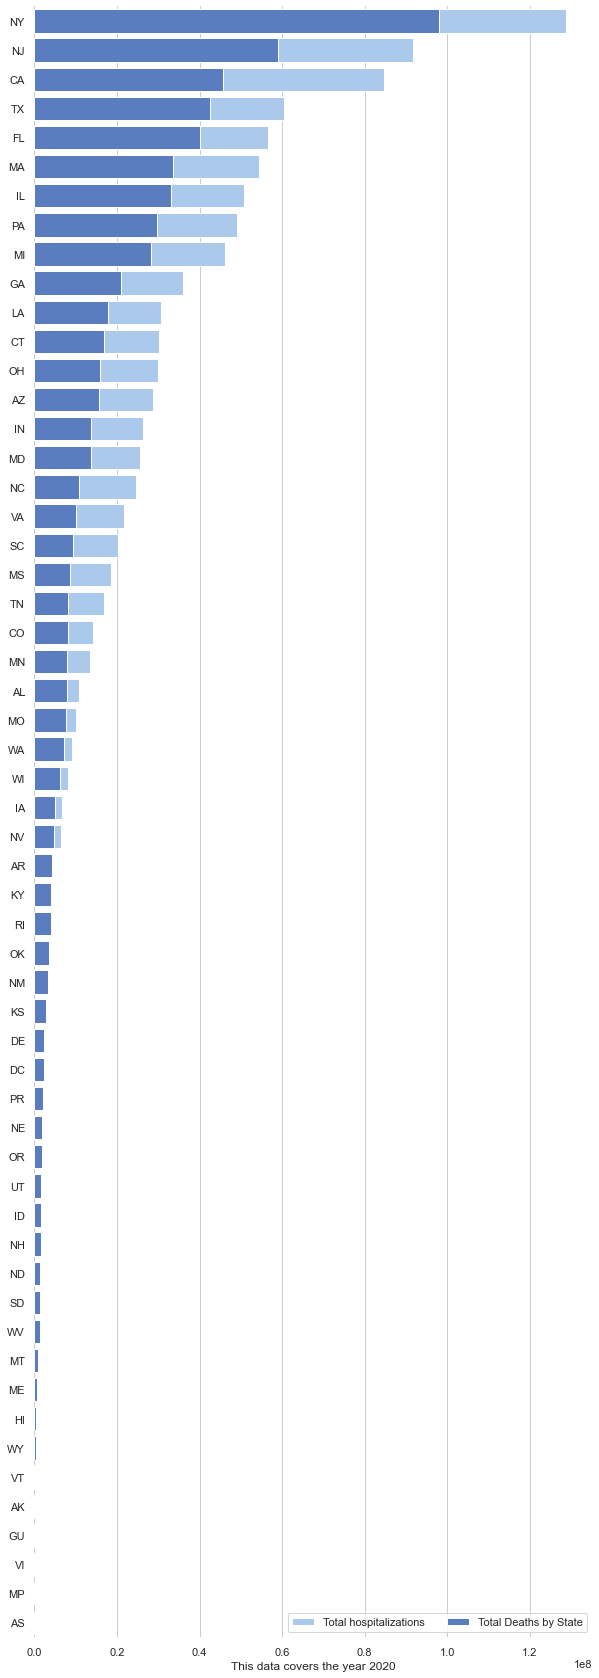

In [6]:
sns.set_theme(style="ticks")

sns.set_theme(style="whitegrid")

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(10, 30))

# Plot the total hospitalizations for 2020
sns.set_color_codes("pastel")
sns.barplot(x="hospitalized", y="state", data=df_pivoted_hospilizations,
            label="Total hospitalizations", color="b", ci=None)

# Plot the total deaths by state for 2020
sns.set_color_codes("muted")
sns.barplot(x="death", y="state", data=df_pivoted_deaths,
            label="Total Deaths by State", color="b", ci=None)

# Add a legend and informative axis label
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(ylabel="",
       xlabel="This data covers the year 2020")
sns.despine(left=True, bottom=True)

plt.show()